Stored 1198 records securely.


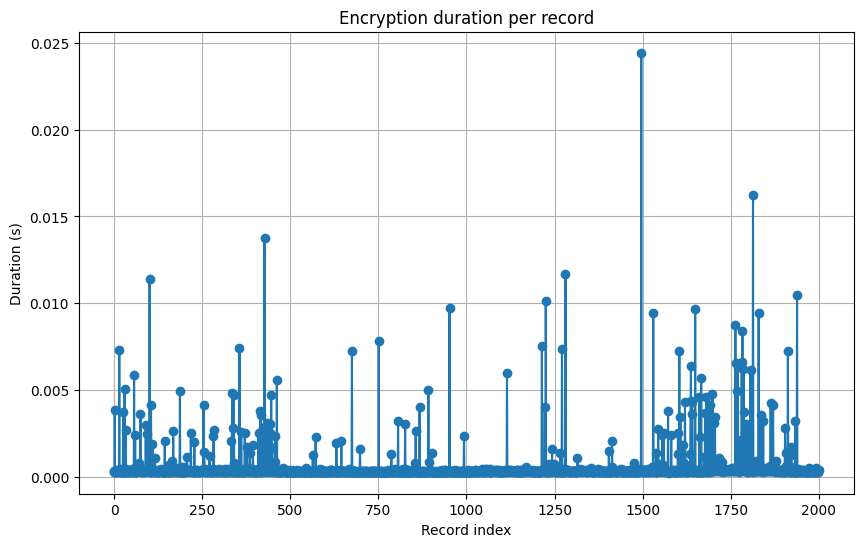

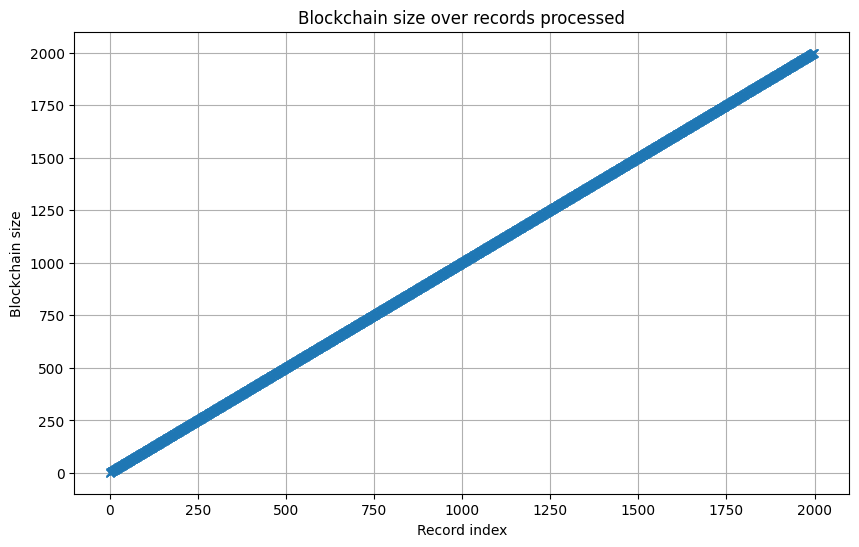

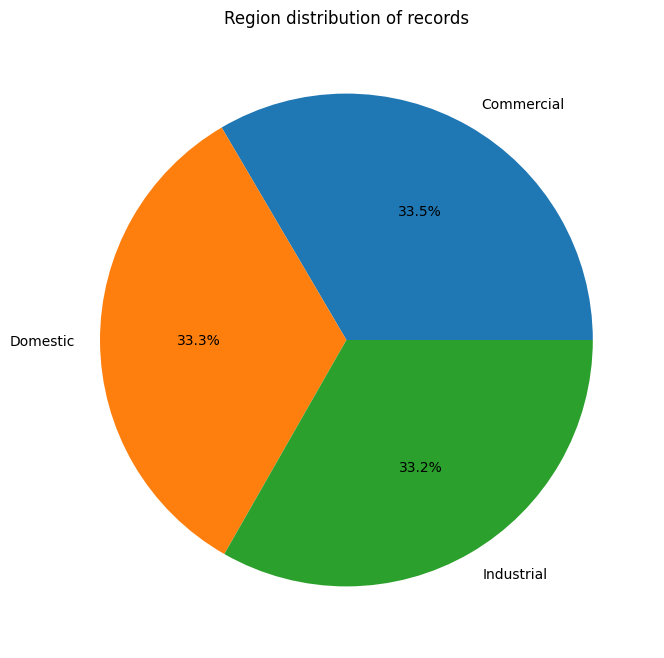

In [ ]:
#==============================simply optimized with charts =======================================
import os
import json
import base64
import hashlib
import pandas as pd
import time
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.serialization import PublicFormat, Encoding

# AES encryption
def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

# RSA key generation
def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

# Encrypt AES key with RSA
def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

# Search token
def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

# Blockchain add
def add_to_blockchain(blockchain, entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    combined = json.dumps(entry, sort_keys=True) + prev_hash
    entry_hash = hashlib.sha256(combined.encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})
    return blockchain

# Worker for parallel processing
def process_row(row, public_key_pem):
    # Deserialize the public key in each worker process
    from cryptography.hazmat.primitives.serialization import load_pem_public_key
    from cryptography.hazmat.backends import default_backend

    public_key = load_pem_public_key(public_key_pem, backend=default_backend())

    start = time.time()
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"]
    }
    aes_key = os.urandom(32)
    encrypted_data = aes_encrypt(json.dumps(meter_data), aes_key)
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, public_key)
    token = create_search_token(row["Date"])
    meta = {"meter_id": meter_data["meter_id"], "region": meter_data["region"]}
    duration = time.time() - start
    return token, encrypted_data, encrypted_key, meta, {"meter_id": meter_data["meter_id"], "date": row["Date"]}, duration, meter_data["region"]

# Main process
def main():
    df = pd.read_csv("/content/Electricity_bill_1k.csv")
    rsa_private_key, rsa_public_key = generate_rsa_keys()

    # Serialize the public key to PEM format
    rsa_public_key_pem = rsa_public_key.public_bytes(
        encoding=Encoding.PEM,
        format=PublicFormat.SubjectPublicKeyInfo
    )

    cloud_storage = {}
    blockchain = []
    durations = []
    blockchain_sizes = []
    regions = []
    with ProcessPoolExecutor() as executor:
        # Pass the serialized public key to the worker processes
        futures = [executor.submit(process_row, row, rsa_public_key_pem) for _, row in df.iterrows()]
        for future in as_completed(futures):
            token, enc_data, enc_key, meta, log_entry, duration, region = future.result()
            cloud_storage[token] = {"enc_data": enc_data, "enc_key": enc_key, "meta": meta}
            blockchain = add_to_blockchain(blockchain, log_entry)
            durations.append(duration)
            blockchain_sizes.append(len(blockchain))
            regions.append(region)
    print(f"Stored {len(cloud_storage)} records securely.")

    # Visualizations
    plt.figure(figsize=(10, 6))
    plt.plot(durations, marker='o')
    plt.title("Encryption duration per record")
    plt.xlabel("Record index")
    plt.ylabel("Duration (s)")
    plt.grid(True)
    plt.savefig("encryption_duration.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(blockchain_sizes, marker='x')
    plt.title("Blockchain size over records processed")
    plt.xlabel("Record index")
    plt.ylabel("Blockchain size")
    plt.grid(True)
    plt.savefig("blockchain_growth.png")
    plt.show()

    region_series = pd.Series(regions)
    region_counts = region_series.value_counts()
    region_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8))
    plt.title("Region distribution of records")
    plt.ylabel("")
    plt.savefig("region_distribution.png")
    plt.show()

if __name__ == "__main__":
    main()

Original dataset sample:


,Name,Address,Account ID,Phone No.,Meter No.,Date,Time,Bill No.,Max Demand,Previous Unit,Present Unit,Billed Unit,Due Date,Total Due,Sanctioned Load,Fixed Amount,Category
0,Miraya Keer,"H.No. 114, Chahal Street, Purnia 567345",1503927654,+91 7849510324,65849108.0,2023-03-04,03:02:39,194741,1,361639,361791,152,2025-03-01,701,3,245,Industrial
1,Yashvi Dass,"07/401, Bhagat Circle, Naihati-638561",3363408132,+91 6931252876,53271366.0,2025-02-14,19:38:31,832735,1,454393,454815,422,2025-03-01,3561,4,818,Domestic
2,Sana Cherian,"825, Kashyap Path, Bhimavaram 762470",1622468629,+91 7230507865,64887623.0,2025-02-21,10:01:12,618790,6,575495,575651,156,2025-03-01,1299,6,831,Commercial
3,Alia Sarna,"H.No. 946, Kaur Street, Maheshtala-517471",9259774576,+91 8779836338,64831720.0,2024-05-06,09:07:36,505087,8,714974,715840,866,2025-03-01,6670,2,608,Commercial
4,Aniruddh Atwal,"H.No. 67, Sastry Chowk, Ballia 265521",2429614095,+91 6797692666,99692127.0,2023-03-06,21:41:20,709415,7,999068,999345,277,2025-03-01,1512,2,127,Commercial


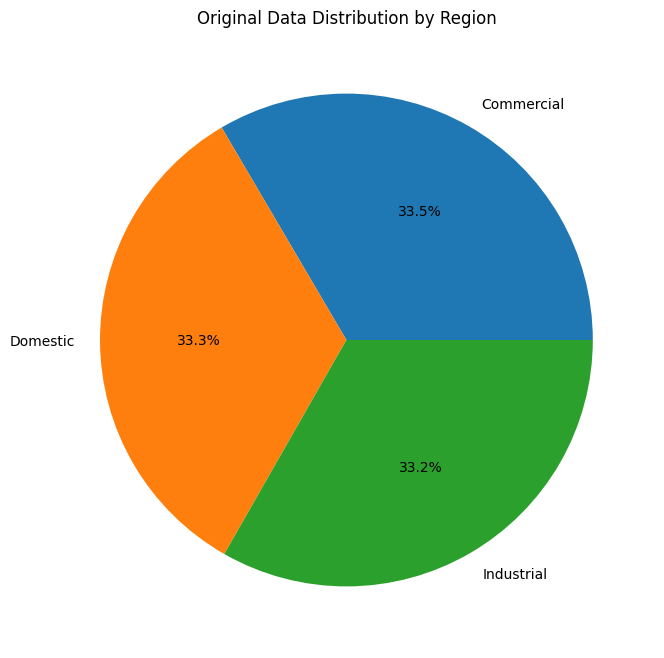

Encrypted data sample (one record):
{
  "enc_data": "E6QJsiAbW3kVInqXnKwv0oFtHJBJUCxQFUvO/932+Ezl6RByTn7e3vBLal04c6xu2/noculbOE/+3RQR2qKfTH4oniNxnRlWdVBSHXGxYmPiWfdBRWTRaH9683VcJLy15IofXEmYnhN2N6ilDWAbmwjCElxwFREEaNhc/HqepSTFH8U4gb+vZ98mmIqs",
  "enc_key": "OsowDOSSIxH4t0UjFADJiN28h2UAfChkNURcCHvtXIrcFhWuRTaxoLDTaFgmPAT94aTESFuk/w9uMLPt5qFReqcTdS/XE+29IiQlVWbVImgZo/JGkSDA6+AAa1Sh9+w0o7sI8H3XWTeWpqSLiVGBtHZBuf6Axzidf8GPOCb2m8qXWrLbsYRntenH543mrXPuZZ8vSwF4XCe8l3AHDgmnY0O4GA1etlbdxyjij030ATnm9Cf3Q74X1Gjn2vec546nnKqQ+oufvYs6p5GwnmvgzZ


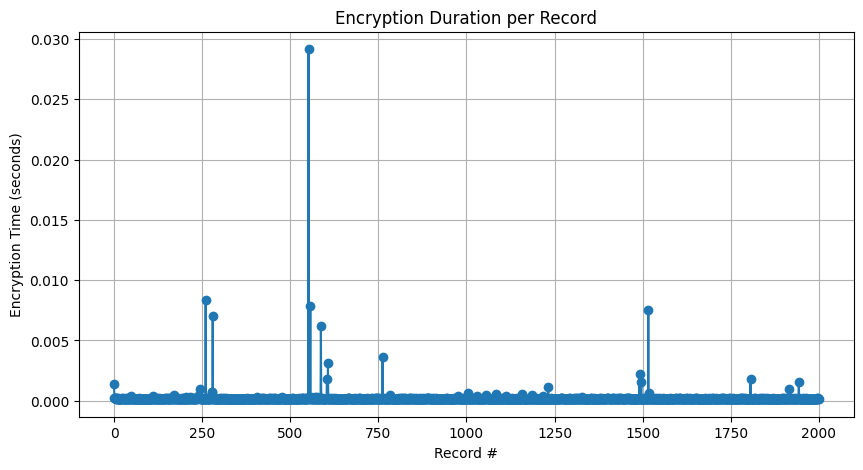

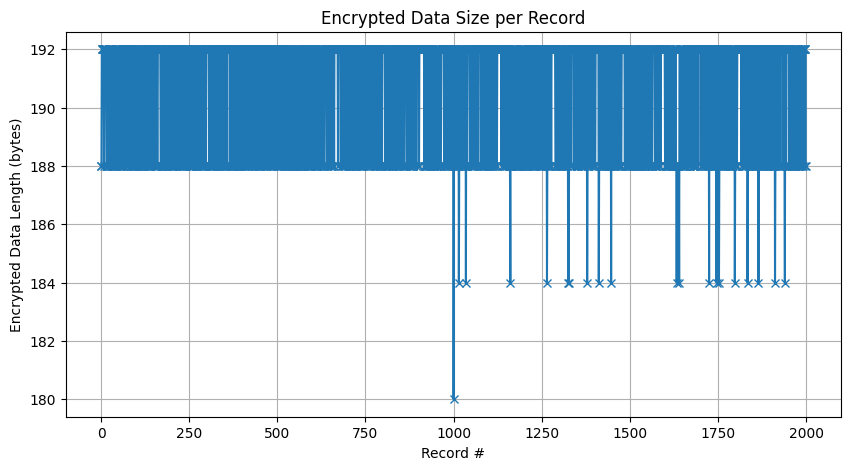

Decryption and comparison:

Original: {'meter_id': '36009906.0', 'timestamp': '2023-03-04T15:25:54', 'billed_units': 121, 'total_due': 911, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2023-03-04'}

Original: {'meter_id': '99769964.0', 'timestamp': '2025-02-14T11:10:00', 'billed_units': 933, 'total_due': 6706, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2025-02-14'}

Original: {'meter_id': '16329481.0', 'timestamp': '2025-02-21T17:23:11', 'billed_units': 733, 'total_due': 7095, 'region': 'Industrial'}
Meta: {'region': 'Industrial', 'date': '2025-02-21'}

Blockchain entries sample:
{
  "entry": {
    "region": "Industrial",
    "date": "2023-03-04"
  },
  "hash": "b602892ef204c8d65ef9e1800b21feba099e8c19580ddc86b7d0716695d54ea2"
}
{
  "entry": {
    "region": "Domestic",
    "date": "2025-02-14"
  },
  "hash": "0832fa9184193fde8786d46e4aeb72a6e65af4295fdef7c72b7b3ad7279a6564"
}
{
  "entry": {
    "region": "Commercial",
    "date": "2025-02-21"
  }

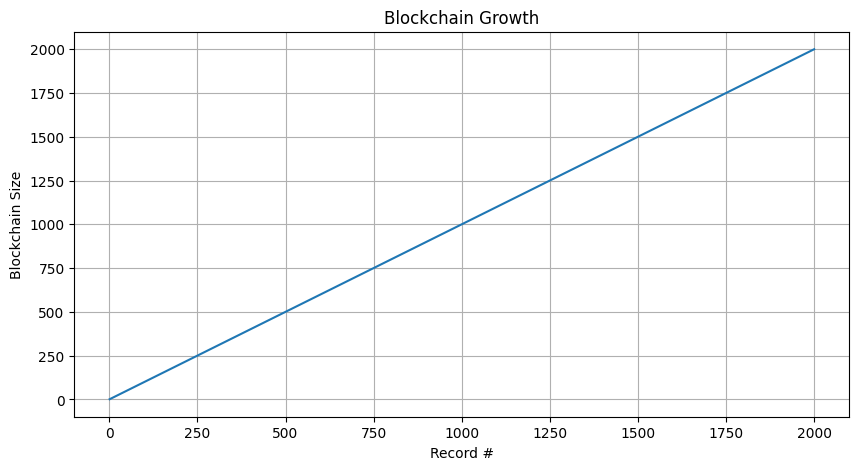


Original hash vs tampered hash (block 1):
Original: b4b66db250e43d2177f0ce5a961424755721de857ce31304bec383c458315e09
Tampered: b4b66db250e43d2177f0ce5a961424755721de857ce31304bec383c458315e09


In [ ]:
#=================================================optimized code with further interpretibility + charts =====================
# =======================
# SETUP
# =======================
import os
import json
import base64
import hashlib
import time
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

os.makedirs("output", exist_ok=True)

# =======================
# FUNCTIONS
# =======================
def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

def aes_decrypt(encrypted_data, key):
    data = base64.b64decode(encrypted_data)
    iv, encrypted = data[:16], data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    decryptor = cipher.decryptor()
    return (decryptor.update(encrypted) + decryptor.finalize()).decode()

def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

def add_to_blockchain(blockchain, entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    combined = json.dumps(entry, sort_keys=True) + prev_hash
    entry_hash = hashlib.sha256(combined.encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})
    return blockchain

# =======================
# LOAD DATASET
# =======================
df = pd.read_csv("/content/Electricity_bill_1k.csv")

# Show original dataset sample
print("Original dataset sample:")
display(df.head())

# Region distribution
region_counts = df["Category"].value_counts()
plt.figure(figsize=(8,8))
region_counts.plot.pie(autopct='%1.1f%%')
plt.title("Original Data Distribution by Region")
plt.ylabel("")
plt.savefig("output/original_region_distribution.png")
plt.show()

# =======================
# ENCRYPTION + CLOUD STORAGE
# =======================
rsa_private_key, rsa_public_key = generate_rsa_keys()
cloud_storage = {}
blockchain = []
timing_list = []
enc_lengths = []

for idx, row in df.iterrows():
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"]
    }

    aes_key = os.urandom(32)
    start_time = time.time()
    encrypted_data = aes_encrypt(json.dumps(meter_data), aes_key)
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, rsa_public_key)
    duration = time.time() - start_time
    timing_list.append(duration)
    enc_lengths.append(len(encrypted_data))

    token = create_search_token(row["Date"])
    cloud_storage[token] = {
        "enc_data": encrypted_data,
        "enc_key": encrypted_key,
        "meta": {"region": row["Category"], "date": row["Date"]}
    }

    blockchain = add_to_blockchain(blockchain, cloud_storage[token]["meta"])

# Show encrypted sample
print("Encrypted data sample (one record):")
sample_token = list(cloud_storage.keys())[0]
print(json.dumps(cloud_storage[sample_token], indent=2)[:500])

# Plot encryption time
plt.figure(figsize=(10,5))
plt.plot(timing_list, marker='o')
plt.xlabel("Record #")
plt.ylabel("Encryption Time (seconds)")
plt.title("Encryption Duration per Record")
plt.grid(True)
plt.savefig("output/encryption_timing.png")
plt.show()

# Plot encrypted data length
plt.figure(figsize=(10,5))
plt.plot(enc_lengths, marker='x')
plt.xlabel("Record #")
plt.ylabel("Encrypted Data Length (bytes)")
plt.title("Encrypted Data Size per Record")
plt.grid(True)
plt.savefig("output/encrypted_data_length.png")
plt.show()

# =======================
# DECRYPTION + COMPARISON
# =======================
print("Decryption and comparison:")

for i, (token, item) in enumerate(cloud_storage.items()):
    dec_aes_key = rsa_private_key.decrypt(
        base64.b64decode(item["enc_key"]),
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    decrypted_data = json.loads(aes_decrypt(item["enc_data"], dec_aes_key))

    if i < 3:
        print(f"\nOriginal: {decrypted_data}")
        print(f"Meta: {item['meta']}")
    if i == 2:
        break

# =======================
# BLOCKCHAIN VIEW + TAMPERING
# =======================
print("\nBlockchain entries sample:")
for b in blockchain[:3]:
    print(json.dumps(b, indent=2))

# Plot blockchain growth
plt.figure(figsize=(10,5))
plt.plot(range(1, len(blockchain)+1), range(1, len(blockchain)+1))
plt.xlabel("Record #")
plt.ylabel("Blockchain Size")
plt.title("Blockchain Growth")
plt.grid(True)
plt.savefig("output/blockchain_growth.png")
plt.show()

# Simulate tampering
tampered_blockchain = blockchain.copy()
tampered_blockchain[1]["entry"]["region"] = "TamperedRegion"
# Recalculate hash for tampered block
prev_hash = tampered_blockchain[0]["hash"]
combined = json.dumps(tampered_blockchain[1]["entry"], sort_keys=True) + prev_hash
tampered_blockchain[1]["hash"] = hashlib.sha256(combined.encode()).hexdigest()

print("\nOriginal hash vs tampered hash (block 1):")
print(f"Original: {blockchain[1]['hash']}")
print(f"Tampered: {tampered_blockchain[1]['hash']}")


Original dataset sample:


,Name,Address,Account ID,Phone No.,Meter No.,Date,Time,Bill No.,Max Demand,Previous Unit,Present Unit,Billed Unit,Due Date,Total Due,Sanctioned Load,Fixed Amount,Category
0,Miraya Keer,"H.No. 114, Chahal Street, Purnia 567345",1503927654,+91 7849510324,65849108.0,2023-03-04,03:02:39,194741,1,361639,361791,152,2025-03-01,701,3,245,Industrial
1,Yashvi Dass,"07/401, Bhagat Circle, Naihati-638561",3363408132,+91 6931252876,53271366.0,2025-02-14,19:38:31,832735,1,454393,454815,422,2025-03-01,3561,4,818,Domestic
2,Sana Cherian,"825, Kashyap Path, Bhimavaram 762470",1622468629,+91 7230507865,64887623.0,2025-02-21,10:01:12,618790,6,575495,575651,156,2025-03-01,1299,6,831,Commercial
3,Alia Sarna,"H.No. 946, Kaur Street, Maheshtala-517471",9259774576,+91 8779836338,64831720.0,2024-05-06,09:07:36,505087,8,714974,715840,866,2025-03-01,6670,2,608,Commercial
4,Aniruddh Atwal,"H.No. 67, Sastry Chowk, Ballia 265521",2429614095,+91 6797692666,99692127.0,2023-03-06,21:41:20,709415,7,999068,999345,277,2025-03-01,1512,2,127,Commercial


Encrypted data sample (one record):
{
  "enc_data": "yL5KA2DM+T8CQ7QVQJKgxyVQLhz+SlVF/HrKB90t+ZQYMRny+LU//6cHzCgOvr2/CLxslOt9suZ2q6b4b/orGig3GvNAun7M7q+/yrq3fX4L+ntE9TnE8KfPAVQva1xPtsrr9m/oA4PI/Kf3jem1KrB4Kz6AeExCdHdeSdAYn1fecq4yHtl9IAcyudl6",
  "enc_key": "cdGHs9IrHWp7K2euLbSZ+qJDjnyLIgh+YTfeI7QEoPN4xjPUBf3nFDh7Qz/8xJNZKV2ou20D84ZxXTIdAw8BdVKX/DgVYeQ8Y62K36/ePBu0+7Cc8NGoUtOY+/Jd5/oe1S/4tj0oYALSUCSexf2EB0P68J0x9f9IsI69QcehjgB/6FemtJTFhCcfk3H5AiImSDUQBjMcofjPnbtjGffLUY1LqCUlyPGzLf+eOOnKqRvjj9YjLME4OsCrcdkY1kWuWrZxtKNPlyJaQ3qtziqcIa
Decryption and comparison:

Original: {'meter_id': '36009906.0', 'timestamp': '2023-03-04T15:25:54', 'billed_units': 121, 'total_due': 911, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2023-03-04'}

Original: {'meter_id': '99769964.0', 'timestamp': '2025-02-14T11:10:00', 'billed_units': 933, 'total_due': 6706, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2025-02-14'}

Original: {'meter_id': '16329481.0', 'timestamp': '202

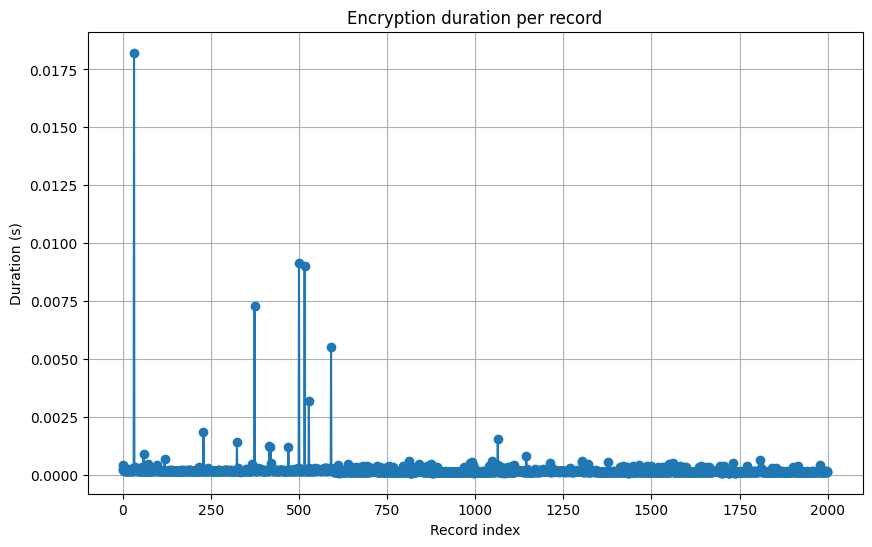

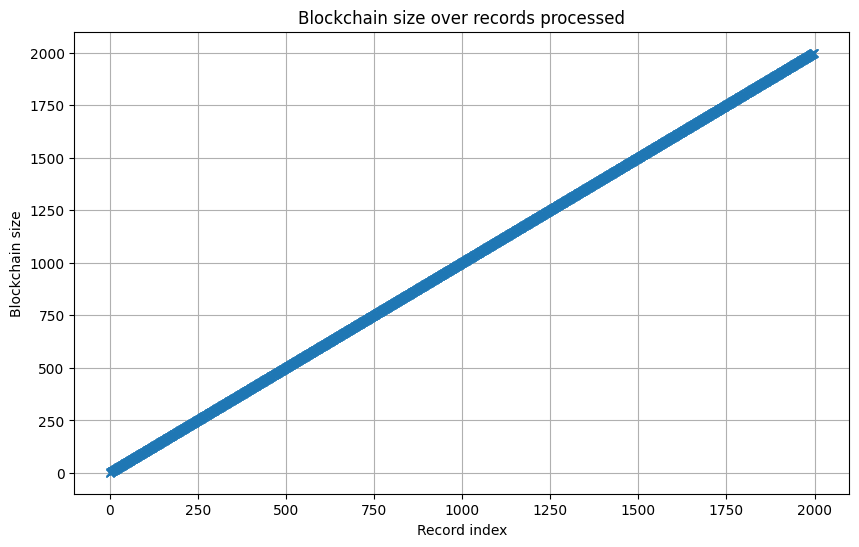

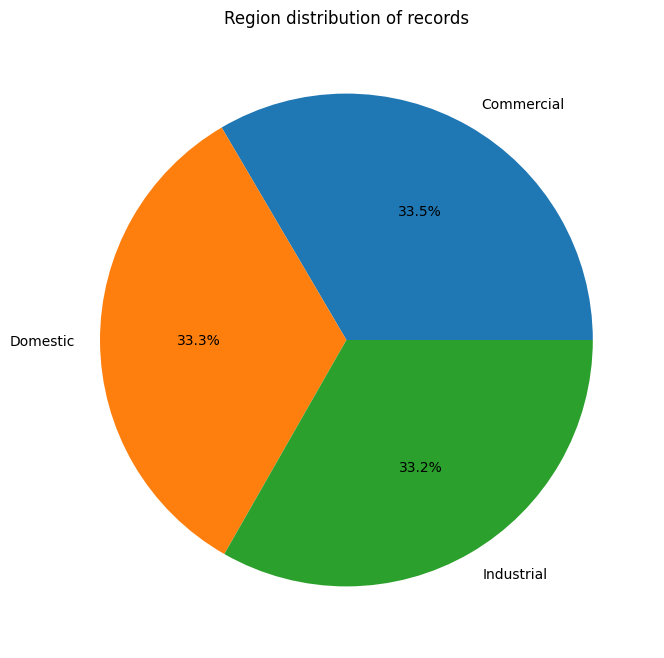

In [ ]:
# =======================
# SETUP
# =======================
import os
import json
import base64
import hashlib
import time
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

os.makedirs("output", exist_ok=True)

# =======================
# FUNCTIONS
# =======================
def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

def aes_decrypt(encrypted_data, key):
    data = base64.b64decode(encrypted_data)
    iv, encrypted = data[:16], data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    decryptor = cipher.decryptor()
    return (decryptor.update(encrypted) + decryptor.finalize()).decode()

def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

def add_to_blockchain(blockchain, entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    combined = json.dumps(entry, sort_keys=True) + prev_hash
    entry_hash = hashlib.sha256(combined.encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})
    return blockchain

def check_blockchain_integrity(blockchain):
    for i in range(1, len(blockchain)):
        prev_hash = blockchain[i-1]["hash"]
        combined = json.dumps(blockchain[i]["entry"], sort_keys=True) + prev_hash
        recalculated_hash = hashlib.sha256(combined.encode()).hexdigest()
        if blockchain[i]["hash"] != recalculated_hash:
            return False, i
    return True, -1

# =======================
# LOAD DATA
# =======================
df = pd.read_csv("Electricity_bill_1k.csv")

print("Original dataset sample:")
display(df.head())

# =======================
# ENCRYPTION + BLOCKCHAIN
# =======================
rsa_private_key, rsa_public_key = generate_rsa_keys()
cloud_storage = {}
blockchain = []
timing_list = []
blockchain_sizes = []
regions = []
decrypted_records = []

for idx, row in df.iterrows():
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"]
    }

    aes_key = os.urandom(32)
    start_time = time.time()
    encrypted_data = aes_encrypt(json.dumps(meter_data), aes_key)
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, rsa_public_key)
    duration = time.time() - start_time
    timing_list.append(duration)

    token = create_search_token(row["Date"])
    cloud_storage[token] = {
        "enc_data": encrypted_data,
        "enc_key": encrypted_key,
        "meta": {"region": row["Category"], "date": row["Date"]}
    }

    blockchain = add_to_blockchain(blockchain, cloud_storage[token]["meta"])
    blockchain_sizes.append(len(blockchain))
    regions.append(row["Category"])

    dec_aes_key = rsa_private_key.decrypt(
        base64.b64decode(encrypted_key),
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    decrypted_data = json.loads(aes_decrypt(encrypted_data, dec_aes_key))
    decrypted_records.append(decrypted_data)

# Show encrypted sample
print("Encrypted data sample (one record):")
sample_token = list(cloud_storage.keys())[0]
print(json.dumps(cloud_storage[sample_token], indent=2)[:500])



# =======================
# DECRYPTION + COMPARISON
# =======================
print("Decryption and comparison:")

for i, (token, item) in enumerate(cloud_storage.items()):
    dec_aes_key = rsa_private_key.decrypt(
        base64.b64decode(item["enc_key"]),
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    decrypted_data = json.loads(aes_decrypt(item["enc_data"], dec_aes_key))

    if i < 3:
        print(f"\nOriginal: {decrypted_data}")
        print(f"Meta: {item['meta']}")
    if i == 2:
        break


# Export decrypted data
pd.DataFrame(decrypted_records).to_csv("output/decrypted_data.csv", index=False)
print("✅ Decrypted data exported to output/decrypted_data.csv")

# =======================
# BLOCKCHAIN VIEW + TAMPERING
# =======================
print("\nBlockchain entries sample:")
for b in blockchain[:3]:
    print(json.dumps(b, indent=2))

# =======================
# TAMPERING + HASH CHECK
# =======================
# Simulate tampering
tampered_blockchain = [json.loads(json.dumps(b)) for b in blockchain]  # Deep copy
tampered_blockchain[1]["entry"]["region"] = "TamperedRegion"

# Compare original hash vs recalculated hash for tampered block
prev_hash = tampered_blockchain[0]["hash"]
combined = json.dumps(tampered_blockchain[1]["entry"], sort_keys=True) + prev_hash
recalculated_hash = hashlib.sha256(combined.encode()).hexdigest()

print("\nOriginal hash vs recalculated hash for tampered block 1:")
print(f"Original stored hash: {tampered_blockchain[1]['hash']}")
print(f"Recalculated hash:    {recalculated_hash}")

# Now check full integrity
is_valid, problem_idx = check_blockchain_integrity(tampered_blockchain)
if not is_valid:
    print(f"❌ Blockchain tampering detected at block {problem_idx}")
else:
    print("✅ Blockchain integrity maintained")

# =======================
# VISUALIZATIONS
# =======================
plt.figure(figsize=(10, 6))
plt.plot(timing_list, marker='o')
plt.title("Encryption duration per record")
plt.xlabel("Record index")
plt.ylabel("Duration (s)")
plt.grid(True)
plt.savefig("output/encryption_duration.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(blockchain_sizes, marker='x')
plt.title("Blockchain size over records processed")
plt.xlabel("Record index")
plt.ylabel("Blockchain size")
plt.grid(True)
plt.savefig("output/blockchain_growth.png")
plt.show()

region_series = pd.Series(regions)
region_counts = region_series.value_counts()
region_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.title("Region distribution of records")
plt.ylabel("")
plt.savefig("output/region_distribution.png")
plt.show()


#=============================Final optimized aes code==================

In [ ]:
#=======================================================final optimized aes code============================
# =======================
# SETUP
# =======================
import os
import json
import base64
import hashlib
import time
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

os.makedirs("output", exist_ok=True)

# =======================
# FUNCTIONS
# =======================
def aes_encrypt(data, key):
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    encryptor = cipher.encryptor()
    encrypted = encryptor.update(data.encode()) + encryptor.finalize()
    return base64.b64encode(iv + encrypted).decode()

def aes_decrypt(encrypted_data, key):
    data = base64.b64decode(encrypted_data)
    iv, encrypted = data[:16], data[16:]
    cipher = Cipher(algorithms.AES(key), modes.CFB(iv))
    decryptor = cipher.decryptor()
    return (decryptor.update(encrypted) + decryptor.finalize()).decode()

def generate_rsa_keys():
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    return private_key, private_key.public_key()

def encrypt_aes_key_with_rsa(aes_key, public_key):
    encrypted = public_key.encrypt(
        aes_key,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    return base64.b64encode(encrypted).decode()

def create_search_token(keyword):
    return hashlib.sha256(keyword.encode()).hexdigest()

def add_to_blockchain(blockchain, entry):
    prev_hash = blockchain[-1]["hash"] if blockchain else "0"
    combined = json.dumps(entry, sort_keys=True) + prev_hash
    entry_hash = hashlib.sha256(combined.encode()).hexdigest()
    blockchain.append({"entry": entry, "hash": entry_hash})
    return blockchain

def check_blockchain_integrity(blockchain):
    for i in range(1, len(blockchain)):
        prev_hash = blockchain[i-1]["hash"]
        combined = json.dumps(blockchain[i]["entry"], sort_keys=True) + prev_hash
        recalculated_hash = hashlib.sha256(combined.encode()).hexdigest()
        if blockchain[i]["hash"] != recalculated_hash:
            return False, i
    return True, -1


In [ ]:

# =======================
# LOAD DATA
# =======================
df = pd.read_csv("Electricity_bill_1k.csv")

print("Original dataset sample:")
display(df.head())


Original dataset sample:


,Name,Address,Account ID,Phone No.,Meter No.,Date,Time,Bill No.,Max Demand,Previous Unit,Present Unit,Billed Unit,Due Date,Total Due,Sanctioned Load,Fixed Amount,Category
0,Miraya Keer,"H.No. 114, Chahal Street, Purnia 567345",1503927654,+91 7849510324,65849108.0,2023-03-04,03:02:39,194741,1,361639,361791,152,2025-03-01,701,3,245,Industrial
1,Yashvi Dass,"07/401, Bhagat Circle, Naihati-638561",3363408132,+91 6931252876,53271366.0,2025-02-14,19:38:31,832735,1,454393,454815,422,2025-03-01,3561,4,818,Domestic
2,Sana Cherian,"825, Kashyap Path, Bhimavaram 762470",1622468629,+91 7230507865,64887623.0,2025-02-21,10:01:12,618790,6,575495,575651,156,2025-03-01,1299,6,831,Commercial
3,Alia Sarna,"H.No. 946, Kaur Street, Maheshtala-517471",9259774576,+91 8779836338,64831720.0,2024-05-06,09:07:36,505087,8,714974,715840,866,2025-03-01,6670,2,608,Commercial
4,Aniruddh Atwal,"H.No. 67, Sastry Chowk, Ballia 265521",2429614095,+91 6797692666,99692127.0,2023-03-06,21:41:20,709415,7,999068,999345,277,2025-03-01,1512,2,127,Commercial


In [ ]:

# =======================
# ENCRYPTION + BLOCKCHAIN
# =======================
rsa_private_key, rsa_public_key = generate_rsa_keys()
cloud_storage = {}
blockchain = []
timing_list = []
blockchain_sizes = []
regions = []
decrypted_records = []
original_json_lengths = []
encrypted_data_lengths = []

for idx, row in df.iterrows():
    meter_data = {
        "meter_id": str(row["Meter No."]),
        "timestamp": f"{row['Date']}T{row['Time']}",
        "billed_units": row["Billed Unit"],
        "total_due": row["Total Due"],
        "region": row["Category"]
    }

    meter_json = json.dumps(meter_data)
    original_json_lengths.append(len(meter_json))

    aes_key = os.urandom(32)
    start_time = time.time()
    encrypted_data = aes_encrypt(meter_json, aes_key)
    encrypted_key = encrypt_aes_key_with_rsa(aes_key, rsa_public_key)
    duration = time.time() - start_time
    timing_list.append(duration)

    encrypted_data_lengths.append(len(encrypted_data))

    token = create_search_token(row["Date"])
    cloud_storage[token] = {
        "enc_data": encrypted_data,
        "enc_key": encrypted_key,
        "meta": {"region": row["Category"], "date": row["Date"]}
    }

    blockchain = add_to_blockchain(blockchain, cloud_storage[token]["meta"])
    blockchain_sizes.append(len(blockchain))
    regions.append(row["Category"])

    dec_aes_key = rsa_private_key.decrypt(
        base64.b64decode(encrypted_key),
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    decrypted_data = json.loads(aes_decrypt(encrypted_data, dec_aes_key))
    decrypted_records.append(decrypted_data)

# Show encrypted sample
print("Encrypted data sample (one record):")
sample_token = list(cloud_storage.keys())[0]
print(json.dumps(cloud_storage[sample_token], indent=2)[:500])

# =======================
# EXPORT ENCRYPTED DATA
# =======================
enc_records = []

for token, item in cloud_storage.items():
    enc_records.append({
        "token": token,
        "enc_data": item["enc_data"],
        "enc_key": item["enc_key"],
        "region": item["meta"]["region"],
        "date": item["meta"]["date"]
    })

enc_df = pd.DataFrame(enc_records)
enc_df.to_csv("output/encrypted_data.csv", index=False)
print("✅ Encrypted data exported to output/encrypted_data.csv")

# print("\nFirst 5 rows of encrypted data:")
# print(enc_df.head())


Encrypted data sample (one record):
{
  "enc_data": "+CPc+qiffqqaKb3pA/yy67jogyQ35e3Kd+h1mZuR0G78jLXZZUYBP4MCikpjiWdmwHFQefb+UycYkpi4WA0lfEfr5FbeleJihUPDV+T4PSY1dlR+0WHHAn13Qd0f5afKKGbXQVdS0kPRlqCzmdMq/mjwr/Yo25eAmEIZ8MFsXc+96FOdZ/0IczQSyVEx",
  "enc_key": "MqpvRrPzoSwRM60yKEGBC/OI1c6zLZWPVvIaFt8f3hyMlYuWEGXtAj2zqN8/rMOTKfL2jdRgpFLq+bYLXR2K54XiuqJ95p2esg/5tqPI0vOtBdcoKl7O/2A+FKUVQFnuEKiGW6NWC8n2ImqiCBWviF2W70/zx0lNVRB7HmFpFMEg2I4d0+GT8dvZzsqGl+u47JqIXC9rUJvvEVxbJFMiAsjIcKjQ2aQQgv4L0N0YnSD9JgfIqAywhrlMw/3vANHttdOyFPmDNgkEiEe+agie84
✅ Encrypted data exported to output/encrypted_data.csv


In [ ]:

# =======================
# DECRYPTION + COMPARISON
# =======================
print("Decryption and comparison:")

for i, (token, item) in enumerate(cloud_storage.items()):
    dec_aes_key = rsa_private_key.decrypt(
        base64.b64decode(item["enc_key"]),
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()), algorithm=hashes.SHA256(), label=None)
    )
    decrypted_data = json.loads(aes_decrypt(item["enc_data"], dec_aes_key))

    if i < 3:
        print(f"\nOriginal: {decrypted_data}")
        print(f"Meta: {item['meta']}")
    if i == 2:
        break

# Export decrypted data
pd.DataFrame(decrypted_records).to_csv("output/decrypted_data.csv", index=False)
print("✅ Decrypted data exported to output/decrypted_data.csv")

# Create DataFrame of decrypted records
dec_df = pd.DataFrame(decrypted_records)

# View first 5 and last 5 rows
print("\nFirst 5 rows of decrypted data:")
print(dec_df.head())


Decryption and comparison:

Original: {'meter_id': '36009906.0', 'timestamp': '2023-03-04T15:25:54', 'billed_units': 121, 'total_due': 911, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2023-03-04'}

Original: {'meter_id': '99769964.0', 'timestamp': '2025-02-14T11:10:00', 'billed_units': 933, 'total_due': 6706, 'region': 'Commercial'}
Meta: {'region': 'Commercial', 'date': '2025-02-14'}

Original: {'meter_id': '16329481.0', 'timestamp': '2025-02-21T17:23:11', 'billed_units': 733, 'total_due': 7095, 'region': 'Industrial'}
Meta: {'region': 'Industrial', 'date': '2025-02-21'}
✅ Decrypted data exported to output/decrypted_data.csv

First 5 rows of decrypted data:
     meter_id            timestamp  billed_units  total_due      region
0  65849108.0  2023-03-04T03:02:39           152        701  Industrial
1  53271366.0  2025-02-14T19:38:31           422       3561    Domestic
2  64887623.0  2025-02-21T10:01:12           156       1299  Commercial
3  64831720.0  2024-05-06

In [ ]:

# =======================
# BLOCKCHAIN VIEW + TAMPERING
# =======================
print("\nBlockchain entries sample:")
for b in blockchain[:3]:
    print(json.dumps(b, indent=2))

# =======================
# TAMPERING + HASH CHECK
# =======================
tampered_blockchain = [json.loads(json.dumps(b)) for b in blockchain]  # Deep copy
tampered_blockchain[1]["entry"]["region"] = "TamperedRegion"

prev_hash = tampered_blockchain[0]["hash"]
combined = json.dumps(tampered_blockchain[1]["entry"], sort_keys=True) + prev_hash
recalculated_hash = hashlib.sha256(combined.encode()).hexdigest()

print("\nOriginal hash vs recalculated hash for tampered block 1:")
print(f"Original stored hash: {tampered_blockchain[1]['hash']}")
print(f"Recalculated hash:    {recalculated_hash}")

is_valid, problem_idx = check_blockchain_integrity(tampered_blockchain)
if not is_valid:
    print(f"❌ Blockchain tampering detected at block {problem_idx}")
else:
    print("✅ Blockchain integrity maintained")



Blockchain entries sample:
{
  "entry": {
    "region": "Industrial",
    "date": "2023-03-04"
  },
  "hash": "b602892ef204c8d65ef9e1800b21feba099e8c19580ddc86b7d0716695d54ea2"
}
{
  "entry": {
    "region": "Domestic",
    "date": "2025-02-14"
  },
  "hash": "0832fa9184193fde8786d46e4aeb72a6e65af4295fdef7c72b7b3ad7279a6564"
}
{
  "entry": {
    "region": "Commercial",
    "date": "2025-02-21"
  },
  "hash": "c4b8cd0f7e425251f47da634af1c72a04021025a0d71ef3256877d93ce4cc73f"
}

Original hash vs recalculated hash for tampered block 1:
Original stored hash: 0832fa9184193fde8786d46e4aeb72a6e65af4295fdef7c72b7b3ad7279a6564
Recalculated hash:    b4b66db250e43d2177f0ce5a961424755721de857ce31304bec383c458315e09
❌ Blockchain tampering detected at block 1


In [ ]:
# =======================
# BLOCKCHAIN VIEW + TAMPERING
# =======================
print("\nBlockchain entries sample:")
for b in blockchain[:3]:
    print(json.dumps(b, indent=2))

# Original tampering + hash check
tampered_blockchain = [json.loads(json.dumps(b)) for b in blockchain]  # Deep copy
tampered_blockchain[1]["entry"]["region"] = "TamperedRegion"

prev_hash = tampered_blockchain[0]["hash"]
combined = json.dumps(tampered_blockchain[1]["entry"], sort_keys=True) + prev_hash
recalculated_hash = hashlib.sha256(combined.encode()).hexdigest()

print("\nOriginal hash vs recalculated hash for tampered block 1:")
print(f"Original stored hash: {tampered_blockchain[1]['hash']}")
print(f"Recalculated hash:    {recalculated_hash}")

is_valid, problem_idx = check_blockchain_integrity(tampered_blockchain)
if not is_valid:
    print(f"❌ Blockchain tampering detected at block {problem_idx}")
else:
    print("✅ Blockchain integrity maintained")

# =======================
# TINY BLOCKCHAIN CLASS + TAMPERING
# =======================
import datetime

class Block:
    def __init__(self, idx, data_hash, prev_hash="0"*64):
        self.index = idx
        self.timestamp = datetime.datetime.utcnow().isoformat()
        self.data_hash = data_hash
        self.prev_hash = prev_hash
        self.hash = self._calc_hash()

    def _calc_hash(self):
        block_str = f"{self.index}{self.timestamp}{self.data_hash}{self.prev_hash}"
        return hashlib.sha256(block_str.encode()).hexdigest()

def build_chain(df_enc: pd.DataFrame):
    chain, prev_hash = [], "0"*64
    for idx, row in df_enc.iterrows():
        row_hash = hashlib.sha256("".join(row.astype(str)).encode()).hexdigest()
        blk = Block(idx, row_hash, prev_hash)
        chain.append(blk)
        prev_hash = blk.hash
    return chain

def chain_valid(chain):
    for i, blk in enumerate(chain):
        if blk.hash != blk._calc_hash():
            return False
        if i > 0 and blk.prev_hash != chain[i-1].hash:
            return False
    return True

def chain_matches_data(chain, df_enc):
    for blk in chain:
        row_hash = hashlib.sha256("".join(df_enc.iloc[blk.index].astype(str)).encode()).hexdigest()
        if row_hash != blk.data_hash:
            return False
    return True

# Build chain on encrypted data
chain = build_chain(enc_df)
print(f"\n⛓️ Blockchain with {len(chain)} blocks created.")
print("   • Chain valid structure:", chain_valid(chain))
print("   • Chain matches data   :", chain_matches_data(chain, enc_df))

print("\n🧱 First 3 blocks:")
for blk in chain[:3]:
    print(f" ▸ Block {blk.index}: hash={blk.hash[:12]}… prev={blk.prev_hash[:12]}… data={blk.data_hash[:12]}…")

# Simulate tampering
print("\n⚠️ Tampering with row #0 'enc_data' → fake value")
enc_df.loc[0, "enc_data"] = "tampered_data_string"

print("   • Old chain still structurally valid:", chain_valid(chain))
print("   • Old chain matches tampered data   :", chain_matches_data(chain, enc_df))

# Rebuild chain on tampered data
new_chain = build_chain(enc_df)
print("   • New chain matches tampered data   :", chain_matches_data(new_chain, enc_df))
print("   • New head hash ≠ old head hash     :", new_chain[-1].hash != chain[-1].hash)



Blockchain entries sample:
{
  "entry": {
    "region": "Industrial",
    "date": "2023-03-04"
  },
  "hash": "b602892ef204c8d65ef9e1800b21feba099e8c19580ddc86b7d0716695d54ea2"
}
{
  "entry": {
    "region": "Domestic",
    "date": "2025-02-14"
  },
  "hash": "0832fa9184193fde8786d46e4aeb72a6e65af4295fdef7c72b7b3ad7279a6564"
}
{
  "entry": {
    "region": "Commercial",
    "date": "2025-02-21"
  },
  "hash": "c4b8cd0f7e425251f47da634af1c72a04021025a0d71ef3256877d93ce4cc73f"
}

Original hash vs recalculated hash for tampered block 1:
Original stored hash: 0832fa9184193fde8786d46e4aeb72a6e65af4295fdef7c72b7b3ad7279a6564
Recalculated hash:    b4b66db250e43d2177f0ce5a961424755721de857ce31304bec383c458315e09
❌ Blockchain tampering detected at block 1

⛓️ Blockchain with 1198 blocks created.
   • Chain valid structure: True
   • Chain matches data   : True

🧱 First 3 blocks:
 ▸ Block 0: hash=0c4198b9ed23… prev=000000000000… data=237977139d53…
 ▸ Block 1: hash=9d789b679585… prev=0c4198b9ed23

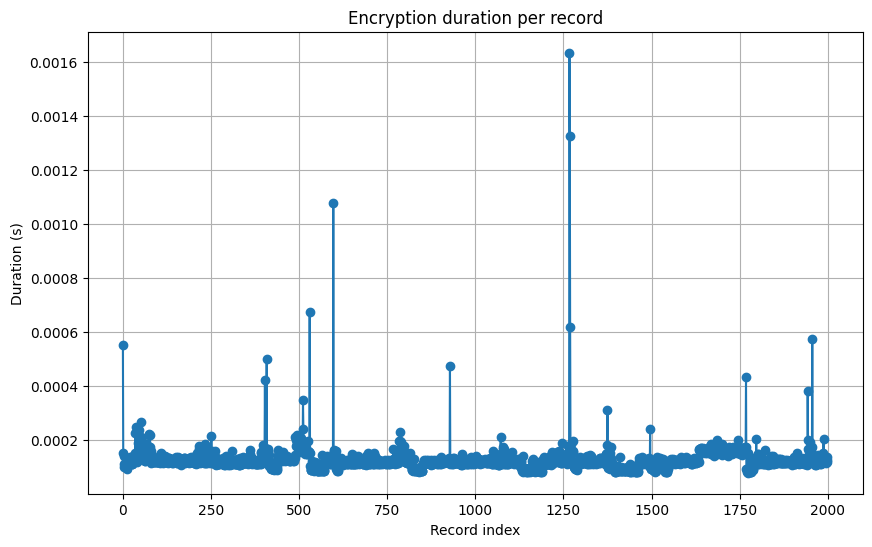

In [ ]:

# =======================
# VISUALIZATIONS
# =======================
plt.figure(figsize=(10, 6))
plt.plot(timing_list, marker='o')
plt.title("Encryption duration per record")
plt.xlabel("Record index")
plt.ylabel("Duration (s)")
plt.grid(True)
plt.savefig("output/encryption_duration.png")
plt.show()


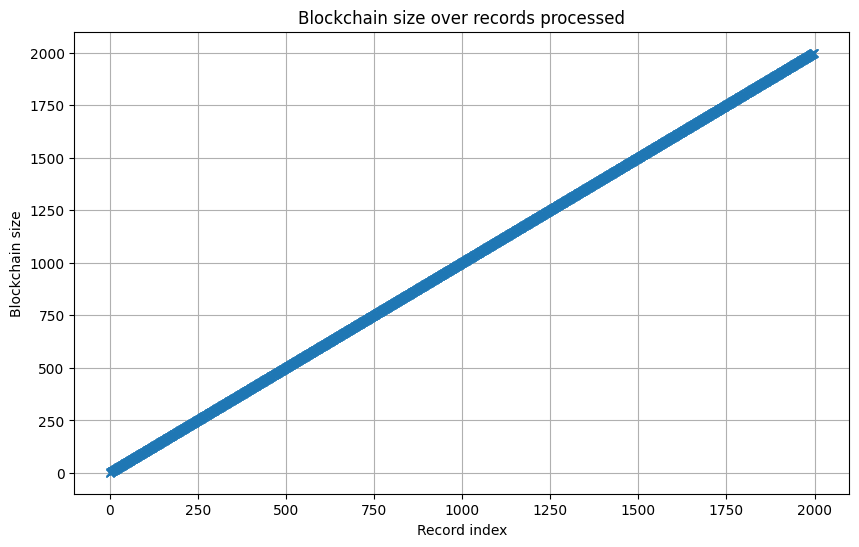

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(blockchain_sizes, marker='x')
plt.title("Blockchain size over records processed")
plt.xlabel("Record index")
plt.ylabel("Blockchain size")
plt.grid(True)
plt.savefig("output/blockchain_growth.png")
plt.show()


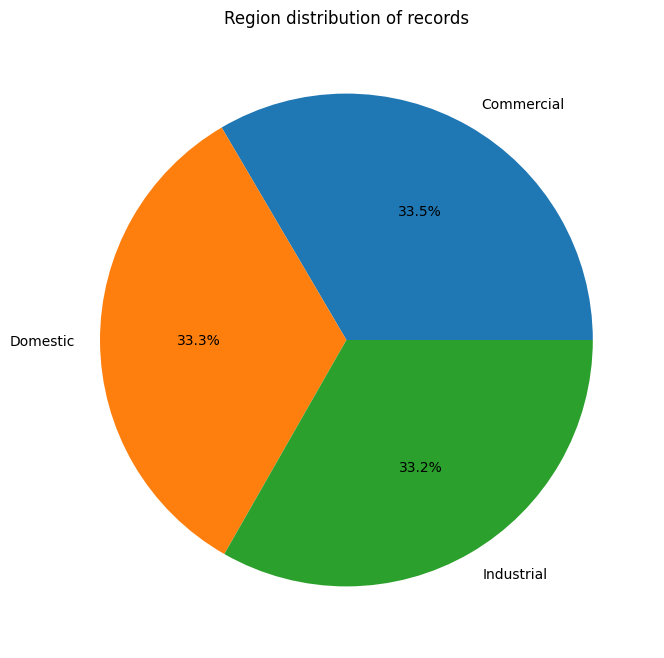

In [ ]:

region_series = pd.Series(regions)
region_counts = region_series.value_counts()
region_counts.plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.title("Region distribution of records")
plt.ylabel("")
plt.savefig("output/region_distribution.png")
plt.show()


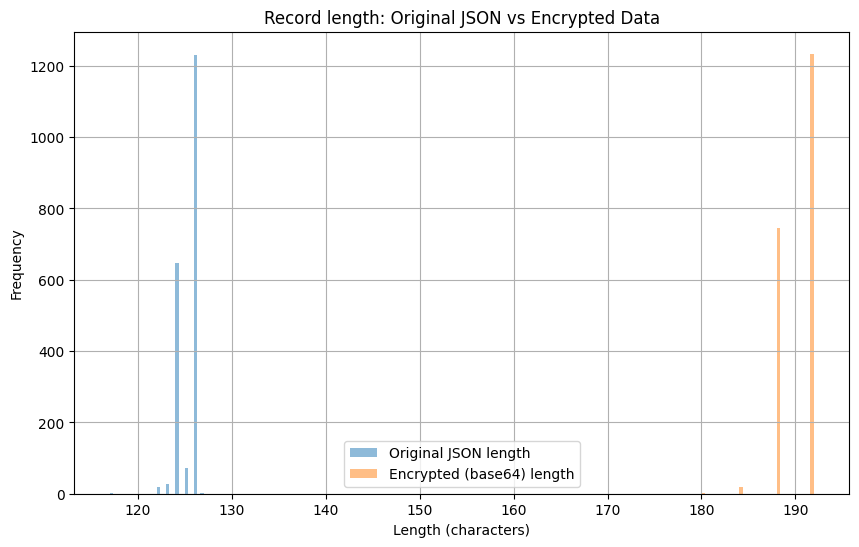

In [ ]:

# =======================
# PLAIN VS ENCRYPTED LENGTH VISUALIZATION
# =======================
plt.figure(figsize=(10,6))
plt.hist(original_json_lengths, bins=30, alpha=0.5, label="Original JSON length")
plt.hist(encrypted_data_lengths, bins=30, alpha=0.5, label="Encrypted (base64) length")
plt.title("Record length: Original JSON vs Encrypted Data")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("output/plain_vs_encrypted_length.png")
plt.show()
